<a href="https://colab.research.google.com/github/tswhy1/Aiffel_quest_cr/blob/main/Python/Node10_project/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install tensorflow-estimator==2.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 kB 7.2 MB/s eta 0:00:00


In [1]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [3]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [4]:
def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [5]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpz374587u.jpg.


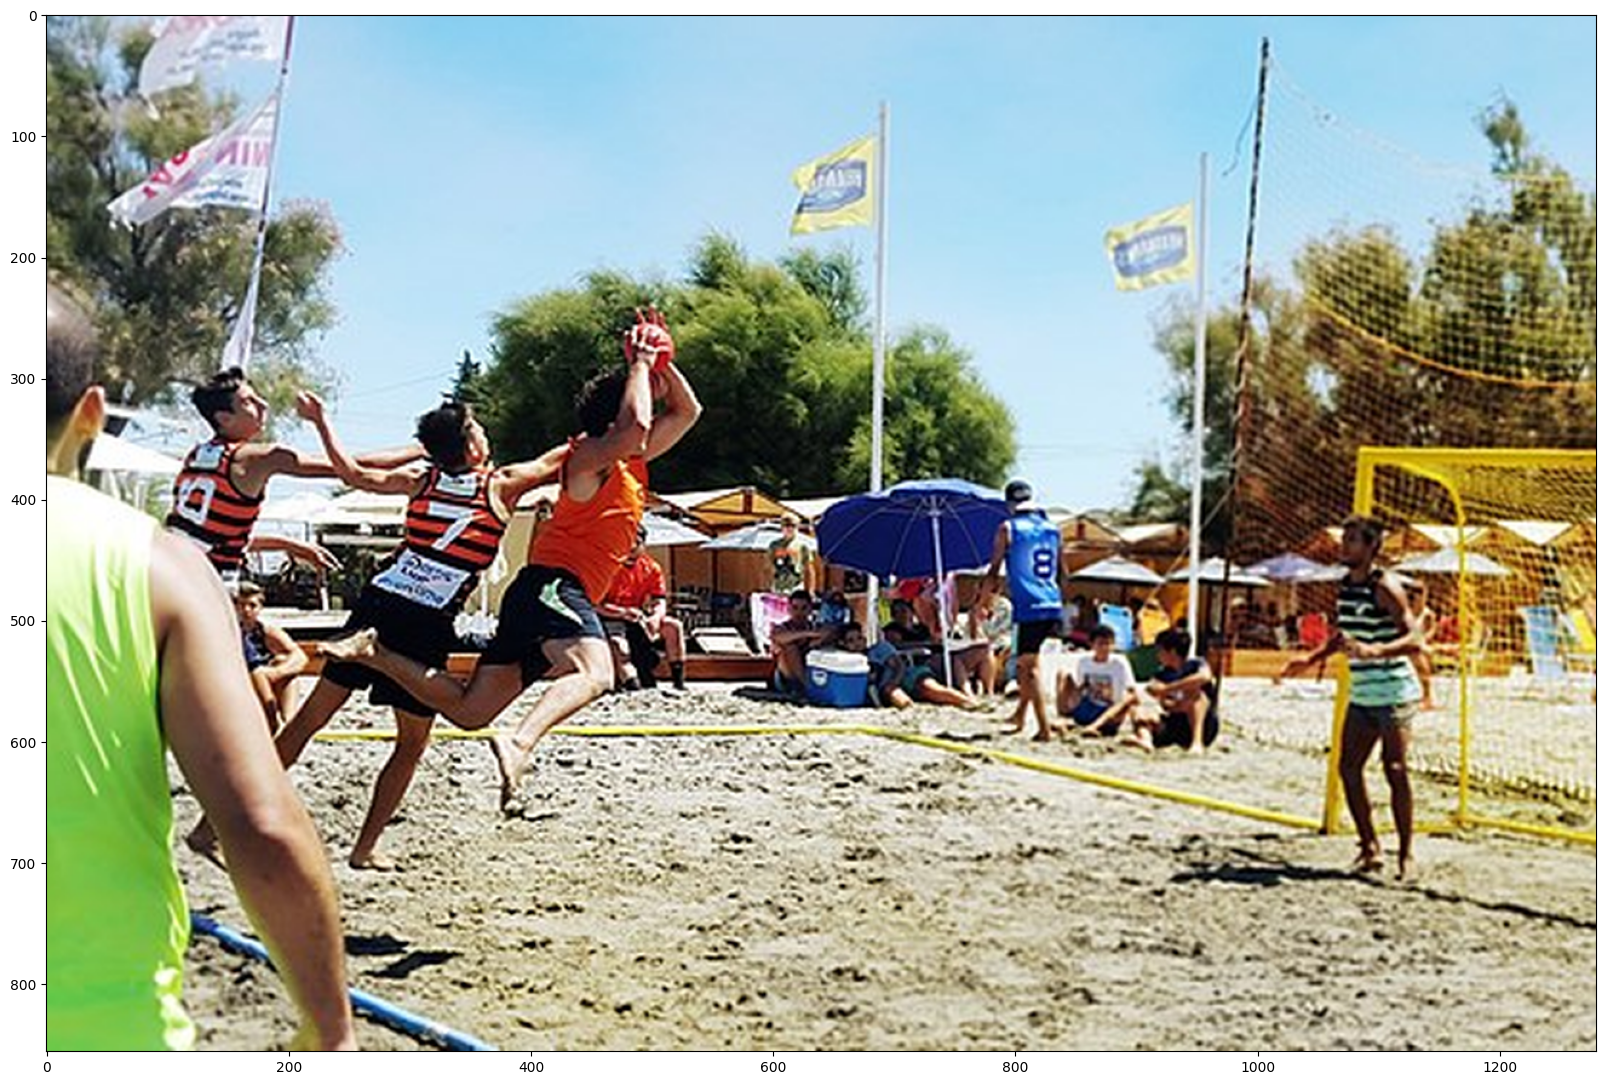

In [10]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    try:
        _, filename = tempfile.mkstemp(suffix=".jpg")
        response = urlopen(url)
        image_data = response.read()
        image_data = BytesIO(image_data)  # 이미지 읽기
        pil_image = Image.open(image_data)
        pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.Resampling.LANCZOS)  # 필터 수정
        pil_image_rgb = pil_image.convert("RGB")  # RGB로 변환
        pil_image_rgb.save(filename, format="JPEG", quality=90)  # 이미지 저장
        print("Image downloaded to %s." % filename)
        if display:
            display_image(pil_image)
        return filename
    except Exception as e:
        print(f"Error downloading or processing the image: {e}")
        return None

# 실행
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageColor
import numpy as np
import time


# Pre-trained Faster R-CNN 모델 URL
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# 모델 로드
try:
    detector = hub.load(module_handle).signatures['default']  # 모델의 'default' 서명을 로드
    print("Faster R-CNN InceptionResNet 모델이 성공적으로 로드되었습니다.")
except Exception as e:
    print(f"모델 로드 중 오류 발생: {e}")


Faster R-CNN InceptionResNet 모델이 성공적으로 로드되었습니다.


In [2]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [3]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color, font, thickness=4, display_str_list=()):
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)
    im_width, im_height = draw_image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)

    # BBox 테두리 그리기
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)

    # 텍스트 크기 계산 (getbbox 사용)
    display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getbbox(display_str)[2] - font.getbbox(display_str)[0], \
                                  font.getbbox(display_str)[3] - font.getbbox(display_str)[1]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

    return draw_image

# Helper 함수: 여러 BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    image_with_boxes = Image.fromarray(np.uint8(image)).convert("RGB")
    draw_image = image_with_boxes.copy()
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 25)
    except IOError:
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            draw_image = draw_bounding_box_on_image(
                draw_image,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
    return np.array(draw_image)


In [4]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    # 소요시간 측정
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key: value.numpy() for key, value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)

    # 이미지 내 박스로 entity, scores를 추가하여 출력
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"]
    )

    display_image(image_with_boxes)

# Helper 함수: 이미지 시각화
def display_image(image):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)
    plt.show()


In [5]:
pip install --upgrade pillow

In [14]:
# 이미지 URL
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"

# TensorFlow 유틸리티로 이미지 다운로드
image_path = tf.keras.utils.get_file("Torneo_beach_handball.jpg", origin=image_url)
print(f"이미지가 다운로드되었습니다: {image_path}")

90847/90847 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
이미지가 다운로드되었습니다: /root/.keras/datasets/Torneo_beach_handball.jpg


Found 100 objects.
Inference time:  3.4485716819763184


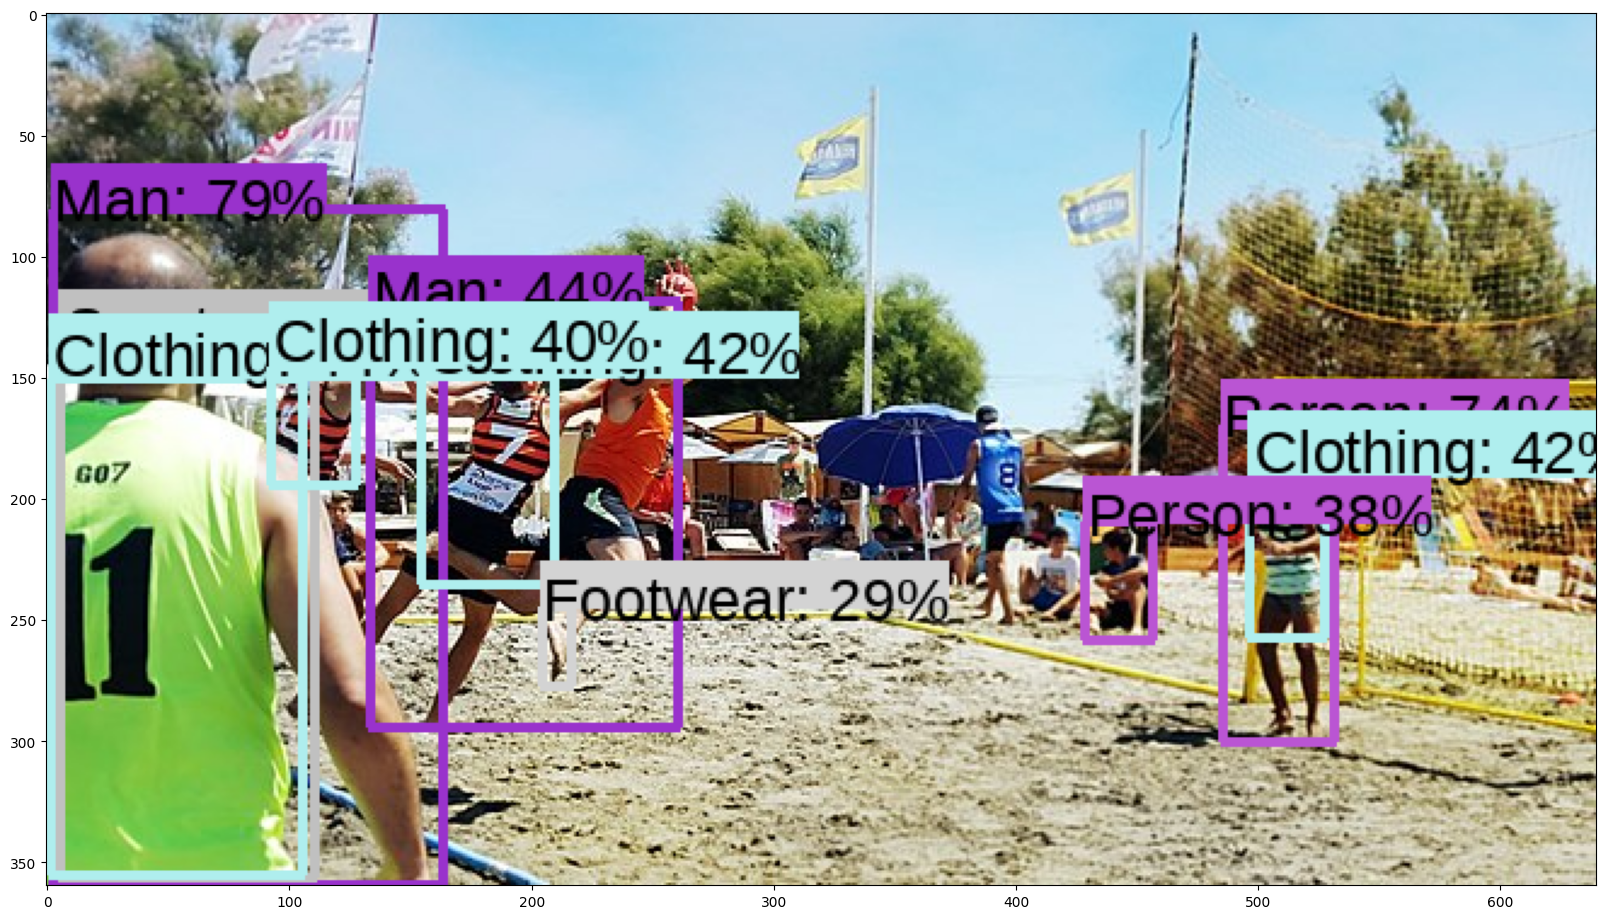

In [15]:
run_detector(detector, image_path)

Image downloaded and saved to /tmp/tmpibrsesmv.jpg


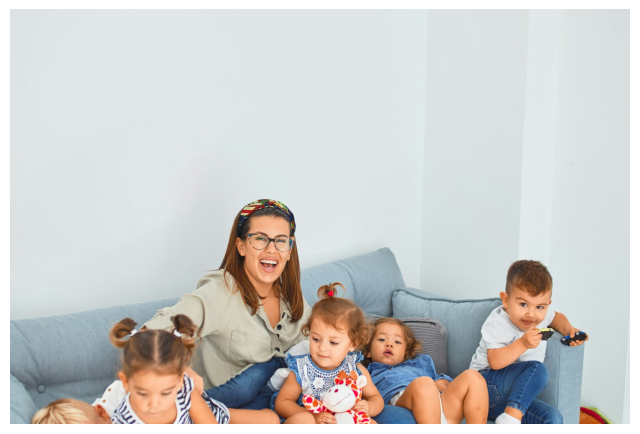

In [23]:
from PIL import Image, ImageOps
from six.moves.urllib.request import urlopen
from six import BytesIO
import tempfile
import matplotlib.pyplot as plt

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    try:
        # 임시 파일 생성
        _, filename = tempfile.mkstemp(suffix=".jpg")
        response = urlopen(url)
        image_data = response.read()
        image_data = BytesIO(image_data)  # 이미지를 메모리에 저장
        pil_image = Image.open(image_data)

        # 이미지 복사 및 리사이즈
        pil_image_copy = pil_image.copy()
        pil_image_resized = ImageOps.fit(pil_image_copy, (new_width, new_height), Image.Resampling.LANCZOS)

        # RGB 변환 및 저장
        pil_image_rgb = pil_image_resized.convert("RGB")
        pil_image_rgb.save(filename, format="JPEG", quality=90)  # 파일 저장
        print(f"Image downloaded and saved to {filename}")

        # 이미지 시각화 (복사본 사용)
        if display:
            plt.figure(figsize=(8, 6))
            plt.imshow(pil_image_resized)
            plt.axis('off')
            plt.show()

        return filename
    except Exception as e:
        print(f"Error downloading and resizing image: {e}")
        return None

# 이미지 URL
image_url_2 = "https://images.unsplash.com/photo-1600880291298-8481039492bc?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
downloaded_image_path_2 = download_and_resize_image(image_url_2, 1280, 856, True)



Found 100 objects.
Inference time:  1.3580656051635742


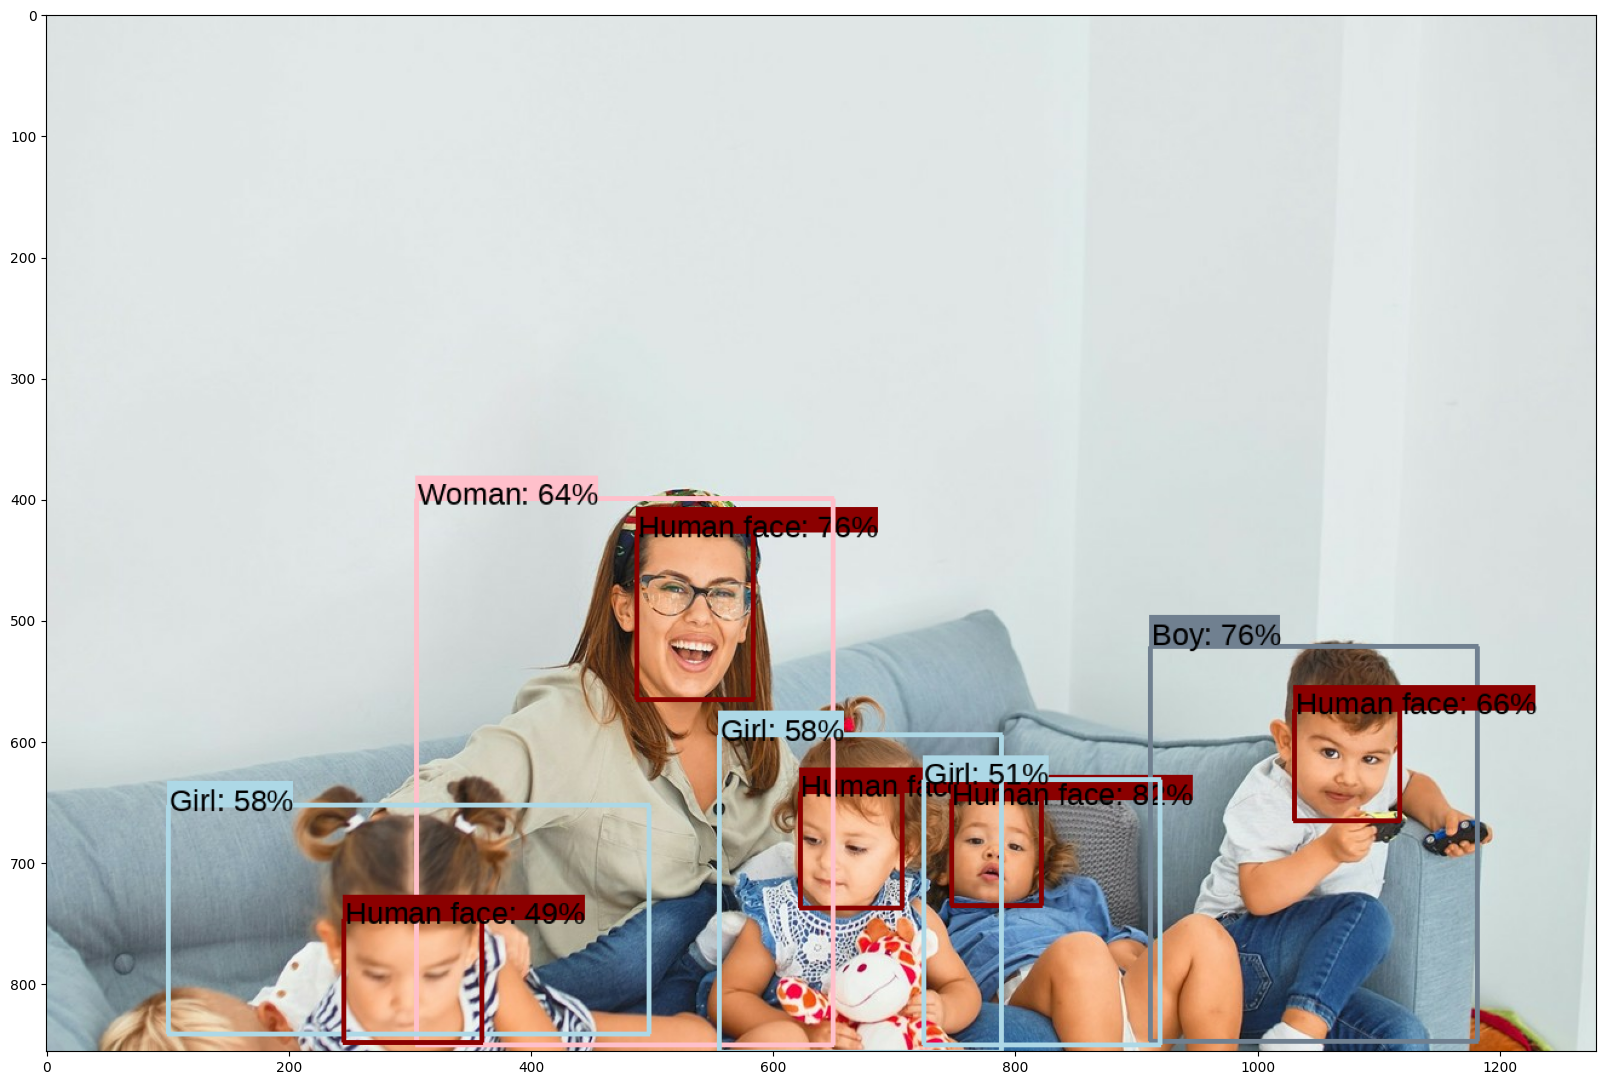

In [24]:
run_detector(detector, downloaded_image_path_2)

In [25]:
# 문제 2-2. 모델 불러오기
module_handle_2 = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector_2 = hub.load(module_handle_2).signatures['default']

Found 100 objects.
Inference time:  9.286116361618042


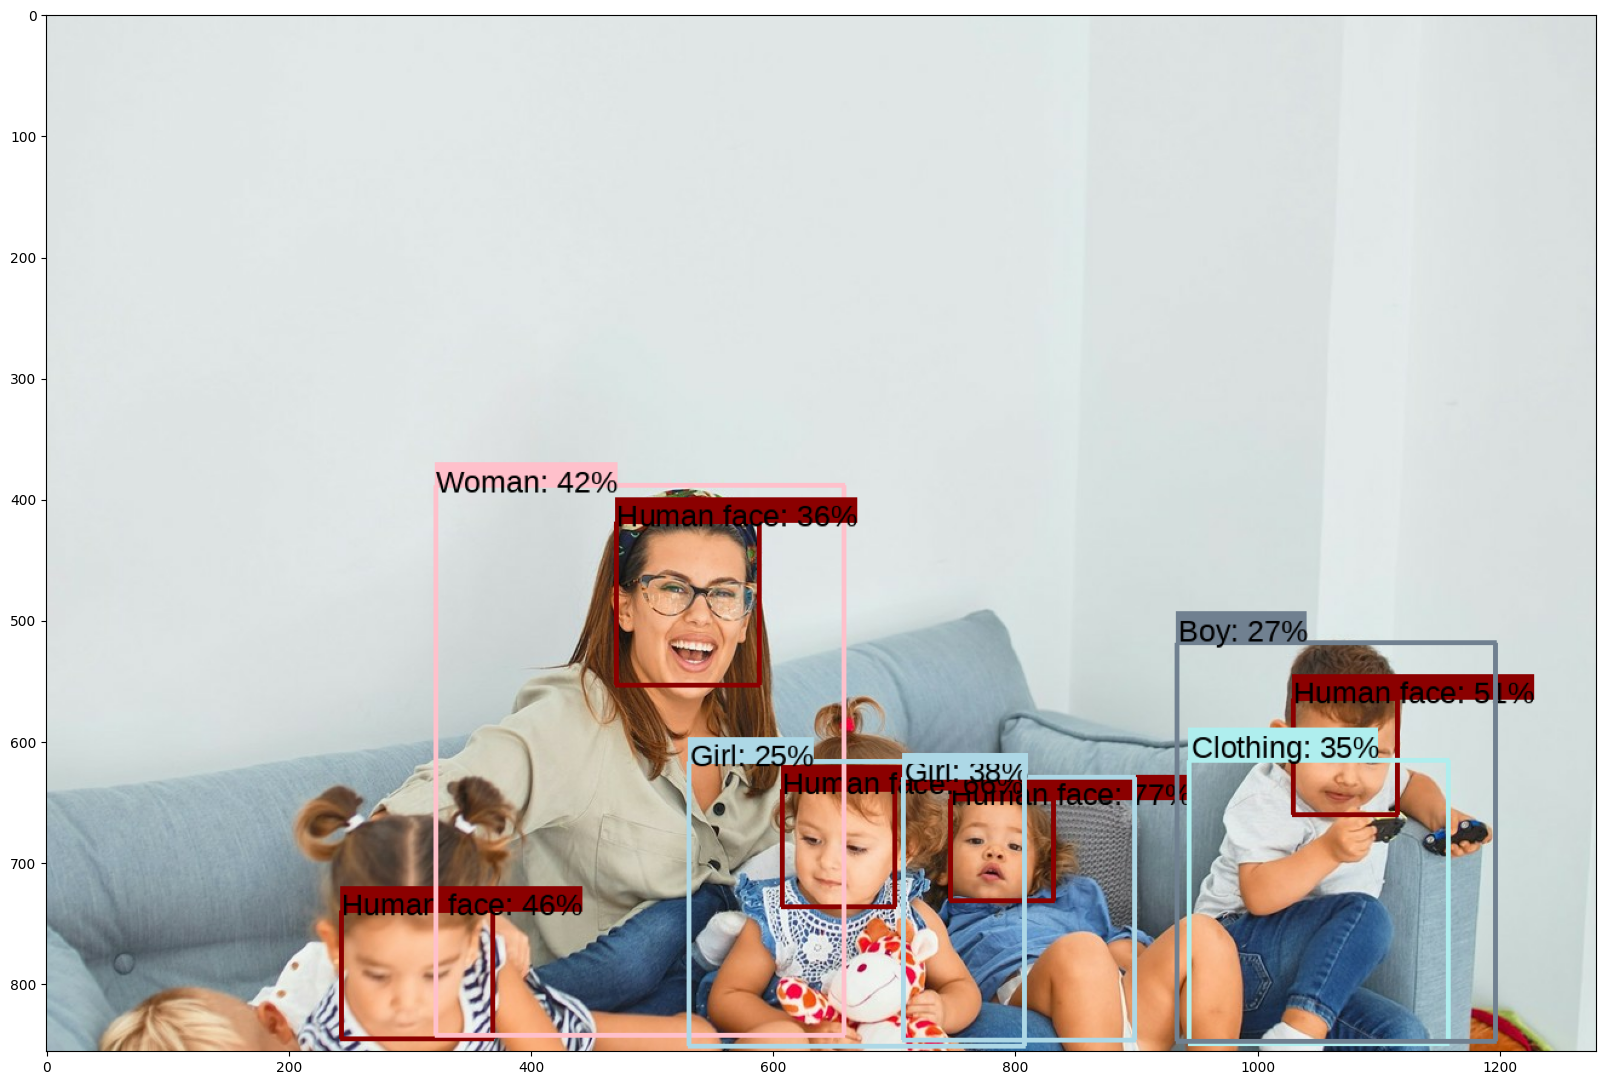

In [26]:
# 문제 2-2. 테스트
run_detector(detector_2, downloaded_image_path_2)

In [21]:
# 문제 2-2. 결과 비교
print("1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.")
print("2번째 모델인 MobileNet을 사용한 Faster RCNN이 상대적으로 낮은 정확성을 보였습니다.")

1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.
2번째 모델인 MobileNet을 사용한 Faster RCNN이 상대적으로 낮은 정확성을 보였습니다.
